# Analysis of PM2.5 Levels in Chinese Cities
## Chris Hayduk

## 1. Introduction

MAKING THIS CHANGE TO TEST FUNCTIONALITY

Atmospheric particulate matter with a diameter of less than 2.5 micrometers (PM2.5) is of significant environmental and health concern. Significant correlations have been shown between the presence of PM2.5 and respiratory mortality [10]. Within the European Union, one study demontrated that high levels of PM2.5 decreased the average life span by 8.6 months [10]. In particular, the American Cancer Society determined in a study based on 500,000 American adults that "the overall mortality and mortality of cardiopulmonary diseases as well as lung cancer increased by 4%, 6% and 8%, respectively, for every 10 µg/m<sup>3</sup> PM2.5 increase" [10]. Moreover, particulate matter emissions from black carbon usage have been shown to accelerate the rate of global warming [1]. While the overall effects of PM on the global climate are still uncertain, the findings regarding PM from black carbon usage suggest that PM from other sources may be a cause for concern for the global climate as well [1].

Given the negative effects of particulate matter, and in particular PM2.5, it is of major practical importance to know when there will be dangerous levels of PM2.5 in the atmosphere. For example, if a city is predicted to have significant levels of PM2.5 on some future date, inhabitants of that city could purchase respirators, which have been shown to be effective in filtering out particulate matter [11]. Hence, the task of predicting days with high levels of PM2.5 can contribute to improving health outcomes in at-risk areas.

In this notebook, we will examine data for five cities within China: Beijing, Chengdu, Guangzhou, Shanghai, and Shenyang. Our goal will be to predict whether or not a city will have dangerously high levels of PM2.5 on a given day, performed over a 30-day prediction window into the future. We will define high PM2.5 levels based on the recommendation from the EPA: 35 µg/m<sup>3</sup> [8]. Furthermore, we see that the shortest distance between any pair of cities in this dataset is about 430 miles between Beijing and Shenyang, whereas several other cities share distances of 1000 miles or more. While PM2.5 is able to travel for long distances, sometimes up to hundreds of miles, the large distances and geographical barriers between cities in our dataset suggest that it may be useful to analyze the particulate matter levels separately. Moreover, each city will have its own distinct pollution sources and climate effects, which may result in differing interactions between predictor variables and differing time series properties for the particulate matter levels. Due to these factors, in this analysis we will treat each city as its own prediction task.

## 2. Data Preprocessing and Cleaning

The dataset for each city is contained in a separate file and consists of the following variables:

* No: row number
* year: year of data in this row
* month: month of data in this row
* day: day of data in this row
* hour: hour of data in this row
* season: season of data in this row
* PM: PM2.5 concentration (µg/m<sup>3</sup>)
* DEWP: Dew Point (Celsius Degree)
* TEMP: Temperature (Celsius Degree)
* HUMI: Humidity (%)
* PRES: Pressure (hPa)
* cbwd: Combined wind direction
* Iws: Cumulated wind speed (m/s)
* precipitation: hourly precipitation (mm)
* Iprec: Cumulated precipitation (mm)

We will begin by loading the data for each city and examining the first 5 rows from the Beijing dataset. This will allow us to get a better idea of the format of the columns and the datatypes that each contain.

In [1022]:
import pandas as pd
import datetime as dt
import numpy as np

beijing = pd.read_csv("BeijingPM20100101_20151231.csv")
chengdu = pd.read_csv("ChengduPM20100101_20151231.csv")
guangzhou = pd.read_csv("GuangzhouPM20100101_20151231.csv")
shanghai = pd.read_csv("ShanghaiPM20100101_20151231.csv")
shenyang = pd.read_csv("ShenyangPM20100101_20151231.csv")

datasets = [beijing, chengdu, guangzhou, shanghai, shenyang]
names = ["Beijing", "Chengdu", "Guangzhou", "Shanghai", "Shenyang"]

beijing.head()

,No,year,month,day,hour,season,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,PM_US_Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
0,1,2010,1,1,0,4,NaN,NaN,NaN,NaN,-21.0,43.0,1021.0,-11.0,NW,1.79,0.0,0.0
1,2,2010,1,1,1,4,NaN,NaN,NaN,NaN,-21.0,47.0,1020.0,-12.0,NW,4.92,0.0,0.0
2,3,2010,1,1,2,4,NaN,NaN,NaN,NaN,-21.0,43.0,1019.0,-11.0,NW,6.71,0.0,0.0
3,4,2010,1,1,3,4,NaN,NaN,NaN,NaN,-21.0,55.0,1019.0,-14.0,NW,9.84,0.0,0.0
4,5,2010,1,1,4,4,NaN,NaN,NaN,NaN,-20.0,51.0,1018.0,-12.0,NW,12.97,0.0,0.0


We can see that our target variable, PM2.5 levels, has been split among four separate columns. Each column represents data collected from a different part of the city at that specific point in time. Since we would like to create a prediction for high levels of PM2.5 in the entire city, we will average the measurements from each location in order to arrive at an estimate for the city as a whole. We will also drop the readings for the individual locations, as we will only be making use of the PM2.5 level for the entire city in our analysis.

In [1023]:
for dataset in datasets:
    dataset['PM'] = dataset.filter(regex=("PM.*")).mean(axis=1)
    dataset.drop(list(dataset.filter(regex=("PM_.*"))), axis = 1, inplace = True)

beijing = datasets[0]
beijing[~np.isnan(beijing["PM"])].head()

,No,year,month,day,hour,season,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec,PM
23,24,2010,1,1,23,4,-17.0,41.0,1020.0,-5.0,cv,0.89,0.0,0.0,129.0
24,25,2010,1,2,0,4,-16.0,38.0,1020.0,-4.0,SE,1.79,0.0,0.0,148.0
25,26,2010,1,2,1,4,-15.0,42.0,1020.0,-4.0,SE,2.68,0.0,0.0,159.0
26,27,2010,1,2,2,4,-11.0,63.5,1021.0,-5.0,SE,3.57,0.0,0.0,181.0
27,28,2010,1,2,3,4,-7.0,85.0,1022.0,-5.0,SE,5.36,0.0,0.0,138.0


We now have hourly estimates for the PM2.5 level in each city. However, we would like to know if PM2.5 levels are high for the day. Hence, it would make sense to aggregate the data given for each day. As a result, we will now take means of the numerical columns grouped by the year, month, and day associated with each row. This will give us a mean value in the city for each variable on a given day. We can simplify this operation by creating a "Date", which will contain the year, month, and day. In addition, datetime objects work quite well with many time series analysis methods implemented in Python, so it will be useful to convert our three temporal columns into a single "Date" column.

Moreover, once we have grouped the data at the daily level using our new "Date" column, we will no longer need the "year", "month", "day", and "hour" columns and can thus drop them. We can also drop the "No" column, as it only provides us with an ordering of the data which is redundant since it can be derived directly from the "Date" column.

In [1024]:
for i in range(len(datasets)):
    datasets[i]["Date"] = datasets[i]["year"].astype(str) + "-" + datasets[i]["month"].astype(str) + "-" + datasets[i]["day"].astype(str)
    datasets[i]["Date"] = pd.to_datetime(datasets[i]["Date"], format = '%Y-%m-%d')
    datasets[i] = datasets[i].groupby(["Date"]).mean()
    datasets[i] = datasets[i].drop(["year", "month", "day", "hour", "No"], axis=1)

beijing = datasets[0]
beijing.head()

,season,DEWP,HUMI,PRES,TEMP,Iws,precipitation,Iprec,PM
Date,,,,,,,,,
2010-01-01,4.0,-18.750000,38.458333,1017.083333,-6.750000,14.458333,0.000000,0.000000,129.000000
2010-01-02,4.0,-8.500000,77.937500,1024.750000,-5.125000,24.860000,0.000000,0.000000,144.333333
2010-01-03,4.0,-10.125000,87.916667,1022.791667,-8.541667,70.937917,0.466667,5.508333,78.375000
2010-01-04,4.0,-20.875000,46.208333,1029.291667,-11.500000,111.160833,0.000000,0.000000,29.291667
2010-01-05,4.0,-24.583333,42.041667,1033.625000,-14.458333,56.920000,0.000000,0.000000,43.541667


We will now attempt to treat the missing values in our dataset. We will begin by examining the missing values for each of our datasets as follows.

In [1025]:
for i in range(len(datasets)):
    print(names[i] + ":")
    print("Number of Observations: " + str(len(datasets[i])))
    print(datasets[i].isna().sum())
    print("\n")

Beijing:
Number of Observations: 2191
season            0
DEWP              0
HUMI             11
PRES             11
TEMP              0
Iws               0
precipitation     8
Iprec             8
PM               36
dtype: int64


Chengdu:
Number of Observations: 2191
season             0
DEWP              19
HUMI              19
PRES              19
TEMP              19
Iws               19
precipitation     99
Iprec             99
PM               899
dtype: int64


Guangzhou:
Number of Observations: 2191
season             0
DEWP               0
HUMI               0
PRES               0
TEMP               0
Iws                0
precipitation      0
Iprec              0
PM               775
dtype: int64


Shanghai:
Number of Observations: 2191
season             0
DEWP               0
HUMI               0
PRES               0
TEMP               0
Iws                0
precipitation    105
Iprec            105
PM               731
dtype: int64


Shenyang:
Number of Observations: 2191

We can see that we have 2191 day-level observations in each of our datasets. The number of missing values varies considerably depending upon the city. Our main variable of interest is PM, and we see that Beijing is missing only 36 day-level observations for PM, representing just 1.6% of the data for our target variable. However, we have Shenyang with 1096 observations missing for PM, representing 50.2% of the total data. Let us now examine Chengdu and Shenyang (the two datasets with the most missing values) in order to see where these missing values seem to be occuring.

In [1026]:
datasets[1].head()

,season,DEWP,HUMI,PRES,TEMP,Iws,precipitation,Iprec,PM
Date,,,,,,,,,
2010-01-01,4.0,2.695652,74.492174,1019.852174,7.260870,1.434783,0.000000,0.000000,NaN
2010-01-02,4.0,3.956522,78.851304,1021.608696,7.434783,2.695652,0.000000,0.000000,NaN
2010-01-03,4.0,3.916667,83.575000,1017.879167,6.541667,3.583333,0.000000,0.000000,NaN
2010-01-04,4.0,3.500000,80.957500,1015.791667,6.666667,2.438750,0.004167,0.004167,NaN
2010-01-05,4.0,2.916667,71.380833,1018.812500,7.916667,1.875000,0.000000,0.000000,NaN


In [1027]:
datasets[4].head()

,season,DEWP,HUMI,PRES,TEMP,Iws,precipitation,Iprec,PM
Date,,,,,,,,,
2010-01-01,4.0,-20.565217,75.884783,1021.173913,-17.347826,27.511539,NaN,NaN,NaN
2010-01-02,4.0,-25.217391,64.335652,1026.173913,-20.086957,3.041909,NaN,NaN,NaN
2010-01-03,4.0,-25.958333,67.212083,1026.833333,-21.416667,8.059512,NaN,NaN,NaN
2010-01-04,4.0,-23.791667,65.102500,1024.375000,-18.833333,4.715729,NaN,NaN,NaN
2010-01-05,4.0,-24.666667,69.441250,1029.375000,-20.416667,2.572204,NaN,NaN,NaN


We can see that there appears to be a lack of data at the beginning of each of these datasets. This suggests that data collection began at a later date in these cities when compared to Beijing. Since we are performing separate analyses for each city, we can drop the rows at the beginning of the dataset which come before particulate matter data collection began. Once we have dropped these rows, we will attempt to fill in the remaining missing values using linear interpolation. Linear interpolation operates by fitting linear polynomials between data points where missing data has occurred. This allows us to construct new data points in the gaps where we have missing data. 

In [1028]:
for i in range(len(datasets)):
    #Get the first index of the dataset with a valid PM value
    first_idx = datasets[i]["PM"].first_valid_index()
    
    #Get the last index of the dataset with a valid PM value
    last_idx = datasets[i]["PM"].last_valid_index()
    
    #Drop the rows with NaN for PM at the beginning and end of the dataset
    datasets[i] = datasets[i].loc[first_idx:last_idx]
    
    datasets[i] = datasets[i].interpolate(limit=35, method='linear', limit_direction='both')
    
    #Print out the details
    print(names[i] + ":")
    print(datasets[i].isna().sum())
    print("\n")

Beijing:
season           0
DEWP             0
HUMI             0
PRES             0
TEMP             0
Iws              0
precipitation    0
Iprec            0
PM               0
dtype: int64


Chengdu:
season           0
DEWP             0
HUMI             0
PRES             0
TEMP             0
Iws              0
precipitation    0
Iprec            0
PM               0
dtype: int64


Guangzhou:
season           0
DEWP             0
HUMI             0
PRES             0
TEMP             0
Iws              0
precipitation    0
Iprec            0
PM               0
dtype: int64


Shanghai:
season           0
DEWP             0
HUMI             0
PRES             0
TEMP             0
Iws              0
precipitation    0
Iprec            0
PM               0
dtype: int64


Shenyang:
season           0
DEWP             0
HUMI             0
PRES             0
TEMP             0
Iws              0
precipitation    0
Iprec            0
PM               0
dtype: int64




After performing our interpolation, we see that all missing data has been filled in for these cities. We can now proceed to adding our column which designates whether or not a specific day had high levels of PM2.5 in the atmosphere. As mentioned in the introduction, our threshold level will be the same as is recommended by the EPA: 35 µg/m<sup>3</sup>. We will then check the percentage of days which have high levels of PM2.5 in each dataset.

In [1029]:
def high_PM(x):
    if x > 35:
        return 1
    else:
        return 0
    
for i in range(len(datasets)):
    datasets[i]["High"] = datasets[i]["PM"].apply(high_PM)
    print(names[i] + ": " + str((datasets[i]["High"].sum())/(len(datasets[i]["High"]))*100))

Beijing: 77.95527156549521
Chengdu: 85.07912584777694
Guangzhou: 61.91744340878829
Shanghai: 67.16723549488054
Shenyang: 79.17808219178082


These figures will provide us with baseline accuracy numbers for our prediction task. For example, if we guessed "High" on any given day for Beijing, we would expect to be correct about 78% of the time. Writing these out for each city, the accuracy thresholds which we would like to surpass are:

* Beijing: 78.0%
* Chengdu: 85.1%
* Guangzhou: 61.9%
* Shanghai: 67.2%
* Shenyang: 79.2%

We will keep these figures in mind when building and evaluating our models in Section 4.

## 3. Data Exploration

We will now begin this section by viewing the time series data for particulate matter levels in each city. This will give us a quick visual indication of the trend, seasonality, and cyclicity present in each dataset. 

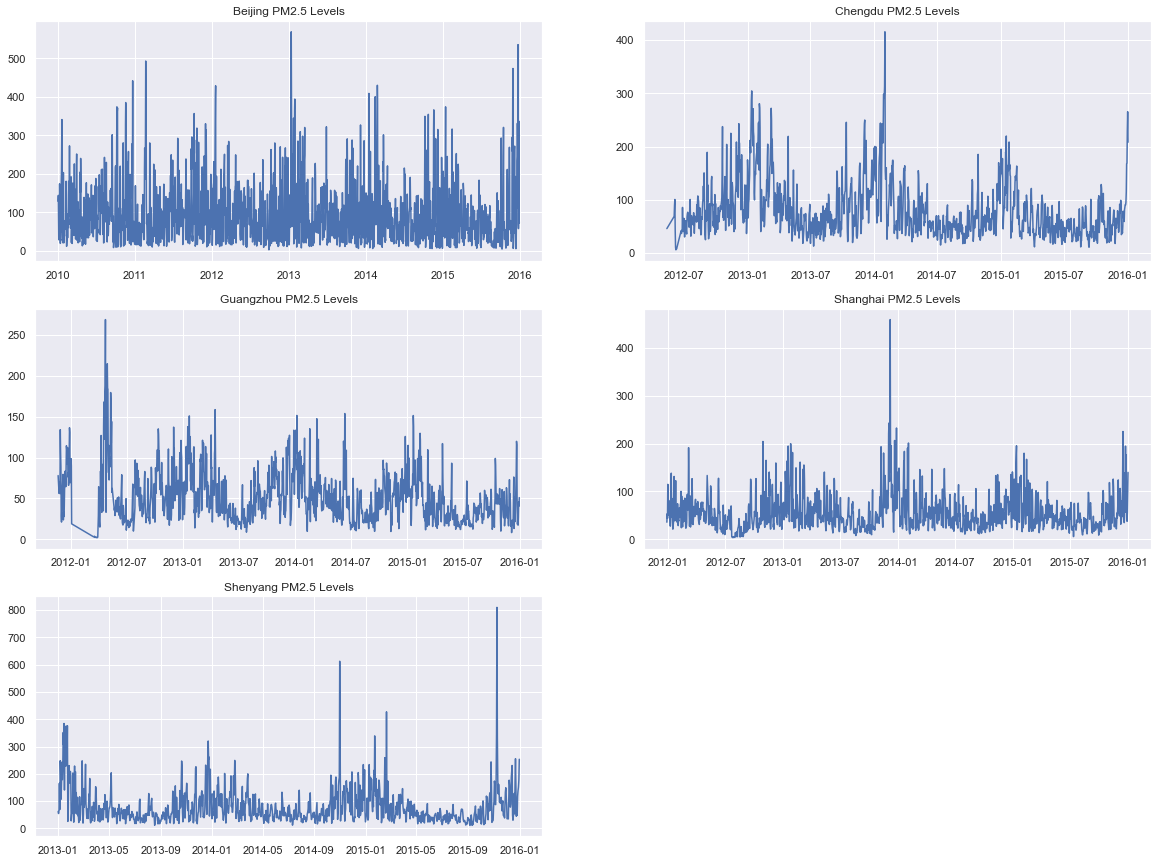

In [1030]:
import matplotlib.pyplot as plt

figure, axis = plt.subplots(3, 2)

figure.set_size_inches(20, 15)

axis[0,0].plot(datasets[0].index, datasets[0]["PM"]) 
axis[0,0].set_title(names[0] + " PM2.5 Levels")

axis[0,1].plot(datasets[1].index, datasets[1]["PM"]) 
axis[0,1].set_title(names[1] + " PM2.5 Levels")

axis[1,0].plot(datasets[2].index, datasets[2]["PM"]) 
axis[1,0].set_title(names[2] + " PM2.5 Levels")

axis[1,1].plot(datasets[3].index, datasets[3]["PM"]) 
axis[1,1].set_title(names[3] + " PM2.5 Levels")

axis[2,0].plot(datasets[4].index, datasets[4]["PM"]) 
axis[2,0].set_title(names[4] + " PM2.5 Levels")

figure.delaxes(axis[2][1])


plt.show()

There is no clear long-term trend in any of the above plots. However, all cities seem to show some level of seasonality, with peaks in particulate matter levels generally occuring around January and troughs occuring around July in each year. In addition, there does not appear to be any significant cyclicity.

We will now directly examine the time series properties of our particulate matter data through the use of a decomposition plot. When we decompose a time series, we typically combine the trend and cycle into a trend-cycle component [9]. We also include a seasonal component and a remainder (or residual) component, which captures anything that the trend-cycle and seasonal components have left out [9]. If we assume that the decomposition is additive, then we can write $$y_t = S_t + T_t + R_t$$ where $y_t$ is the data, $S_t$ is the seasonal component, $T_t$ is the trend-cycle component, and $R_t$ is the remainder component, with $t$ as the time period [9]. It is also possible to use a multiplicative decomposition; however, this is only used when the variation in the seasonal pattern or the trend-cycle pattern changes is proportional to the level of the time series [9]. As we can see from our time series plots above, this does not appear to be the case. Hence, we will use the additive model when decomposing our particulate matter data. Thus, we will plot the additive decomposition of the PM time series from all 5 cities in order to ensure we understand the patterns present in the data from each location.

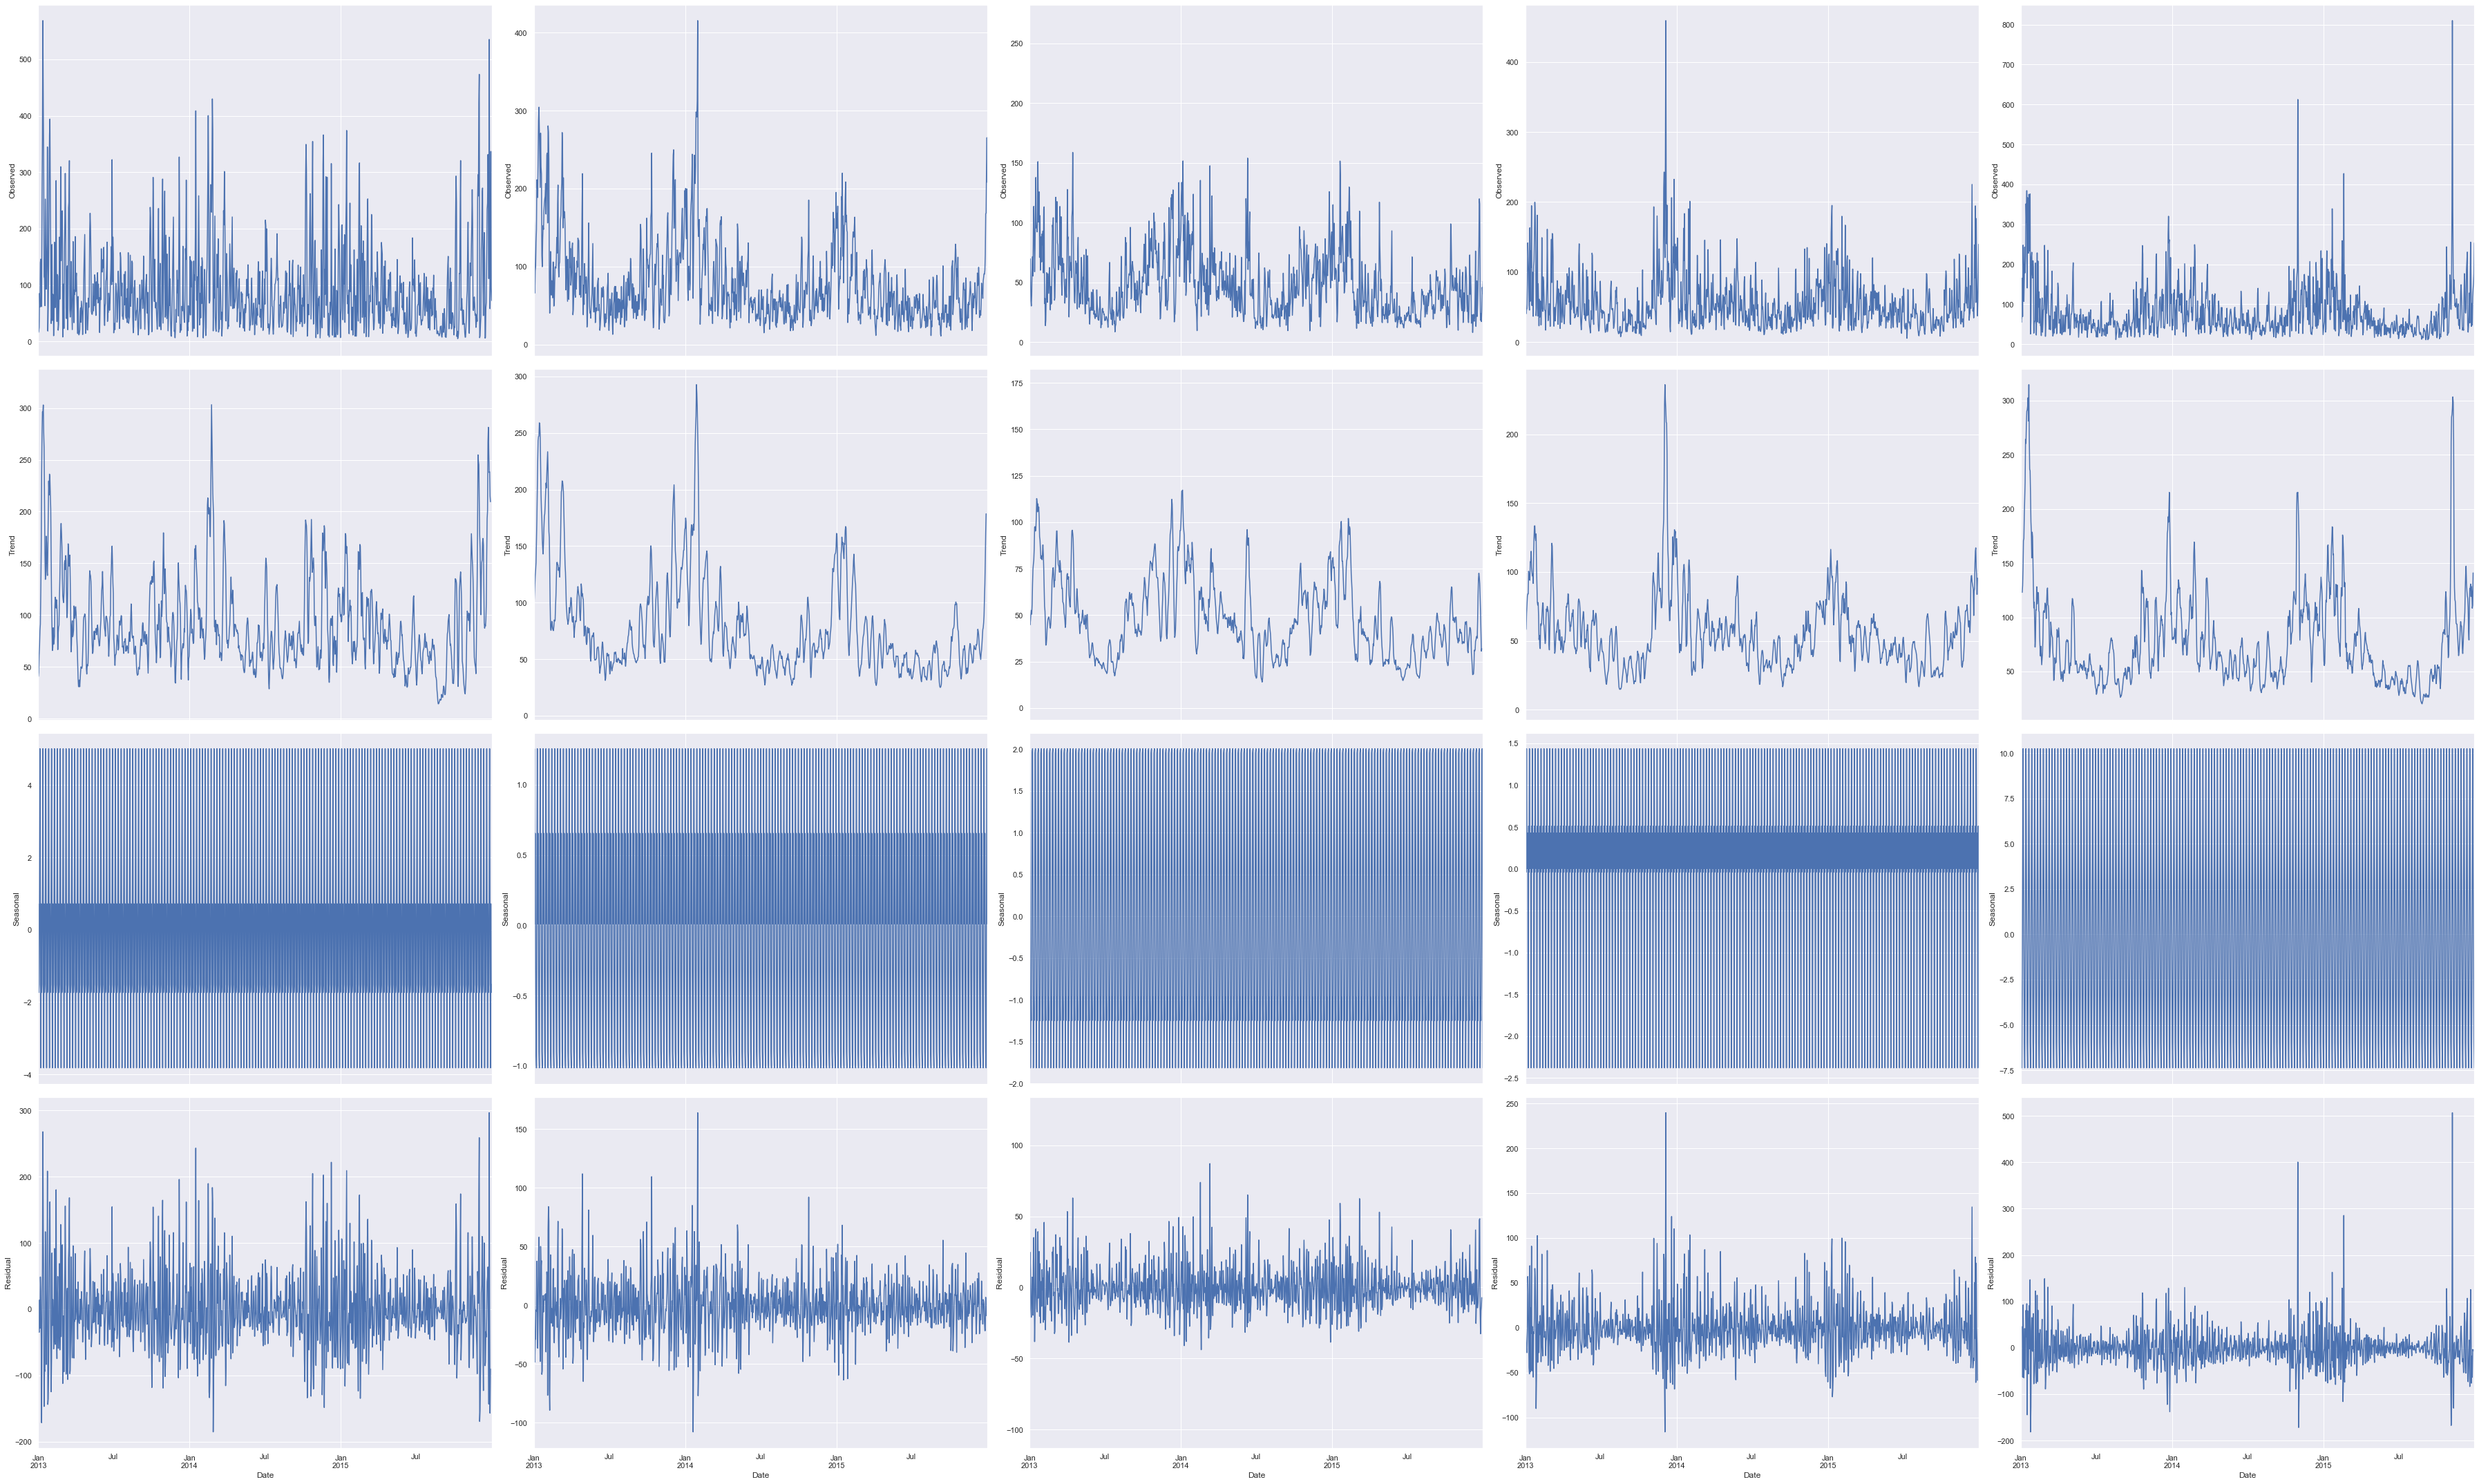

In [1031]:
import statsmodels.api as sm
import warnings

warnings.filterwarnings("ignore")

decomps = []

for dataset in datasets:
    PM_data = dataset["PM"]
    decomps.append(sm.tsa.seasonal_decompose(PM_data, model='additive'))

def plotseasonal(res, axes ):
    res.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observed')
    res.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')
    res.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    res.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual')


fig, axes = plt.subplots(ncols=5, nrows=4, sharex=True, figsize=(50,30))

for i in range(len(decomps)):
    plotseasonal(decomps[i], axes[:,i])

plt.tight_layout()
plt.show()

From all of these plots, we can see that the particulate matter data from each city has trends with very irregular patterns. However, each city's PM levels contain very regular seasonaility, an attribute which our time series models in the following section will be able to exploit.

We will now use an autocorrelation function (ACF) plot in order to view the correlation between points of differing lag values. A lag value is how far back we have to travel in time in order to reach that observation [9]. For example, let us fix ourselves at some observation at time $t$. A lag of 0 would indicate that we are considering the correlation between the observation at time $t$ and time $t$ (ie. itself), a lag of 1 would indicate that we are considering the correlation between the observation at time $t$ and time $t-1$, and so on [9]. These autocorrelation figures will help us to determine how far back in time we should look when modeling our time series data. Before we create these plots, we should also note that the autocorrelation of a sample of white noise will have a value of approximately 0 at all lags other than 0 [9]. Hence, in order to ensure that there really is an exploitable time series structure to our PM data, we should ensure that at least one other time lag greater than 0 has a correlation with our observation that is statistically significant from 0. In the plots below, generated by the statsmodels Python package, a 95% confidence interval for a correlation of 0 is represented as a shaded cone. Hence, any correlation values that are outside the cone represent lag values where the autocorrelation is statistically different from 0. These lag values will be ones that we should consider adding into our models.

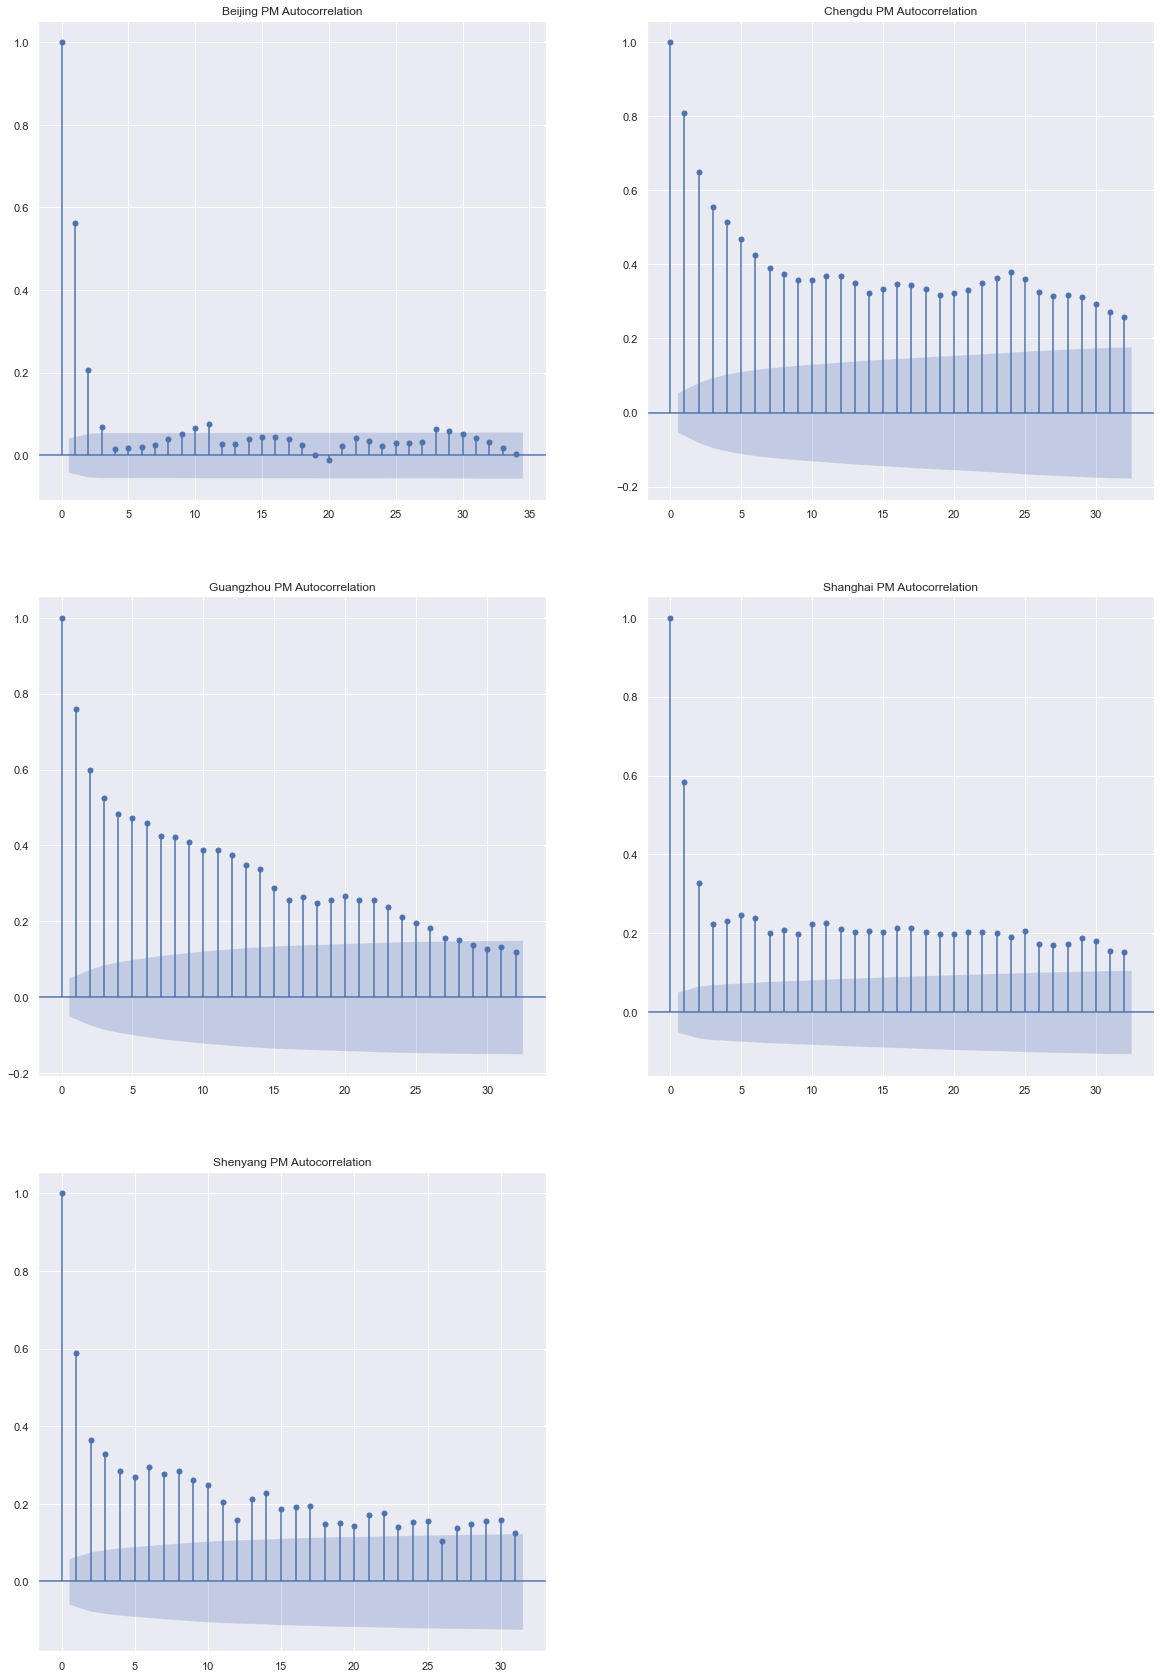

In [1032]:
from statsmodels.graphics.tsaplots import plot_acf

figure, axis = plt.subplots(3, 2)

plot_acf(datasets[0]["PM"], title=names[0] + " PM Autocorrelation", ax=axis[0,0])
plot_acf(datasets[1]["PM"], title=names[1] + " PM Autocorrelation", ax=axis[0,1])
plot_acf(datasets[2]["PM"], title=names[2] + " PM Autocorrelation", ax=axis[1,0])
plot_acf(datasets[3]["PM"], title=names[3] + " PM Autocorrelation", ax=axis[1,1])
plot_acf(datasets[4]["PM"], title=names[4] + " PM Autocorrelation", ax=axis[2,0])


figure.delaxes(axis[2][1])

figure.set_size_inches(20, 30)

plt.show()

We see that even in the least autocorrelated dataset, Beijing, at least 2 lags will be very useful when predicting the next PM value. However, in the other datasets, we see substantially more autocorrelation. In fact, each dataset displays quite different patterns of autocorrelation. This could be due to a variety of factors - it is possible that the climate, geography, and urban layout in each city changes the length of time that PM2.5 will remain in the air of the city. This further justifies our decision to treat each location as its own prediction task.

We will now check the ACF plots for the other continuous variables in our dataset. In order to avoid cluttering the notebook, we will check these only for the Beijing dataset.

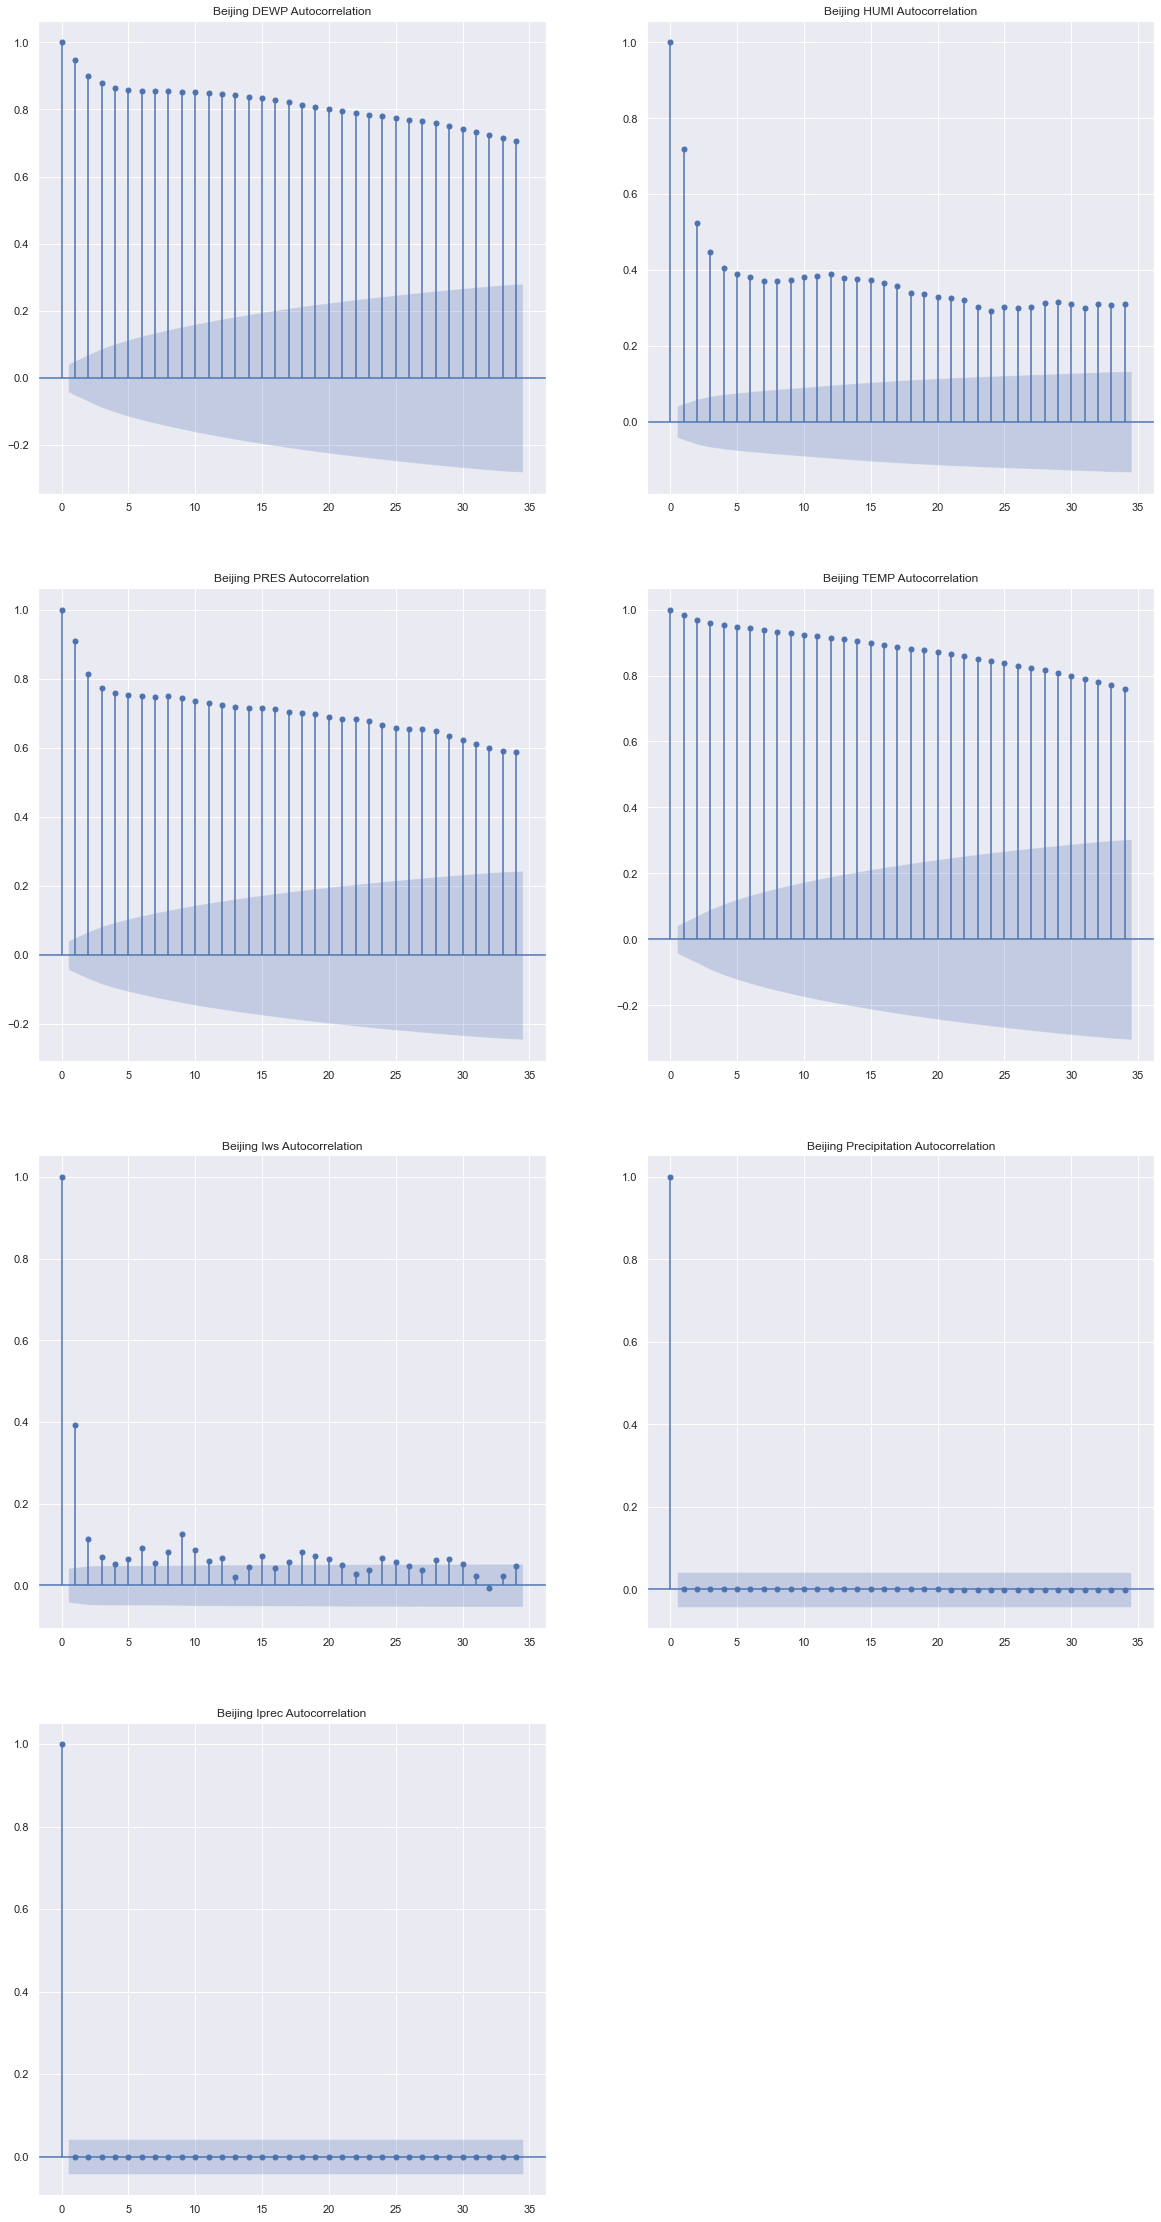

In [1033]:
figure, axis = plt.subplots(4, 2)

plot_acf(datasets[0]["DEWP"], title=names[0] + " DEWP Autocorrelation", ax=axis[0,0])
plot_acf(datasets[0]["HUMI"], title=names[0] + " HUMI Autocorrelation", ax=axis[0,1])
plot_acf(datasets[0]["PRES"], title=names[0] + " PRES Autocorrelation", ax=axis[1,0])
plot_acf(datasets[0]["TEMP"], title=names[0] + " TEMP Autocorrelation", ax=axis[1,1])
plot_acf(datasets[0]["Iws"], title=names[0] + " Iws Autocorrelation", ax=axis[2,0])
plot_acf(datasets[0]["precipitation"], title=names[0] + " Precipitation Autocorrelation", ax=axis[2,1])
plot_acf(datasets[0]["Iprec"], title=names[0] + " Iprec Autocorrelation", ax=axis[3,0])
figure.delaxes(axis[3][1])

figure.set_size_inches(20, 40)

plt.show()

We see that DEWP, HUMI, PRES, and TEMP display huge amounts of autocorrelation - significantly more than PM. On the other hand, Iws displays about the same number of autocorrelated lags as PM, and Precipitation and Iprec display no autocorrelation at all. We will keep these relationships in mind when building our models in the following section, as these graphs will inform the number of lag variables we should be using for each of these predictors.

We can now look at the relationships between variables using a scatterplot matrix. These graphs are quite large and so again, in order to avoid cluttering our analysis, we will only examine the Beijing dataset.

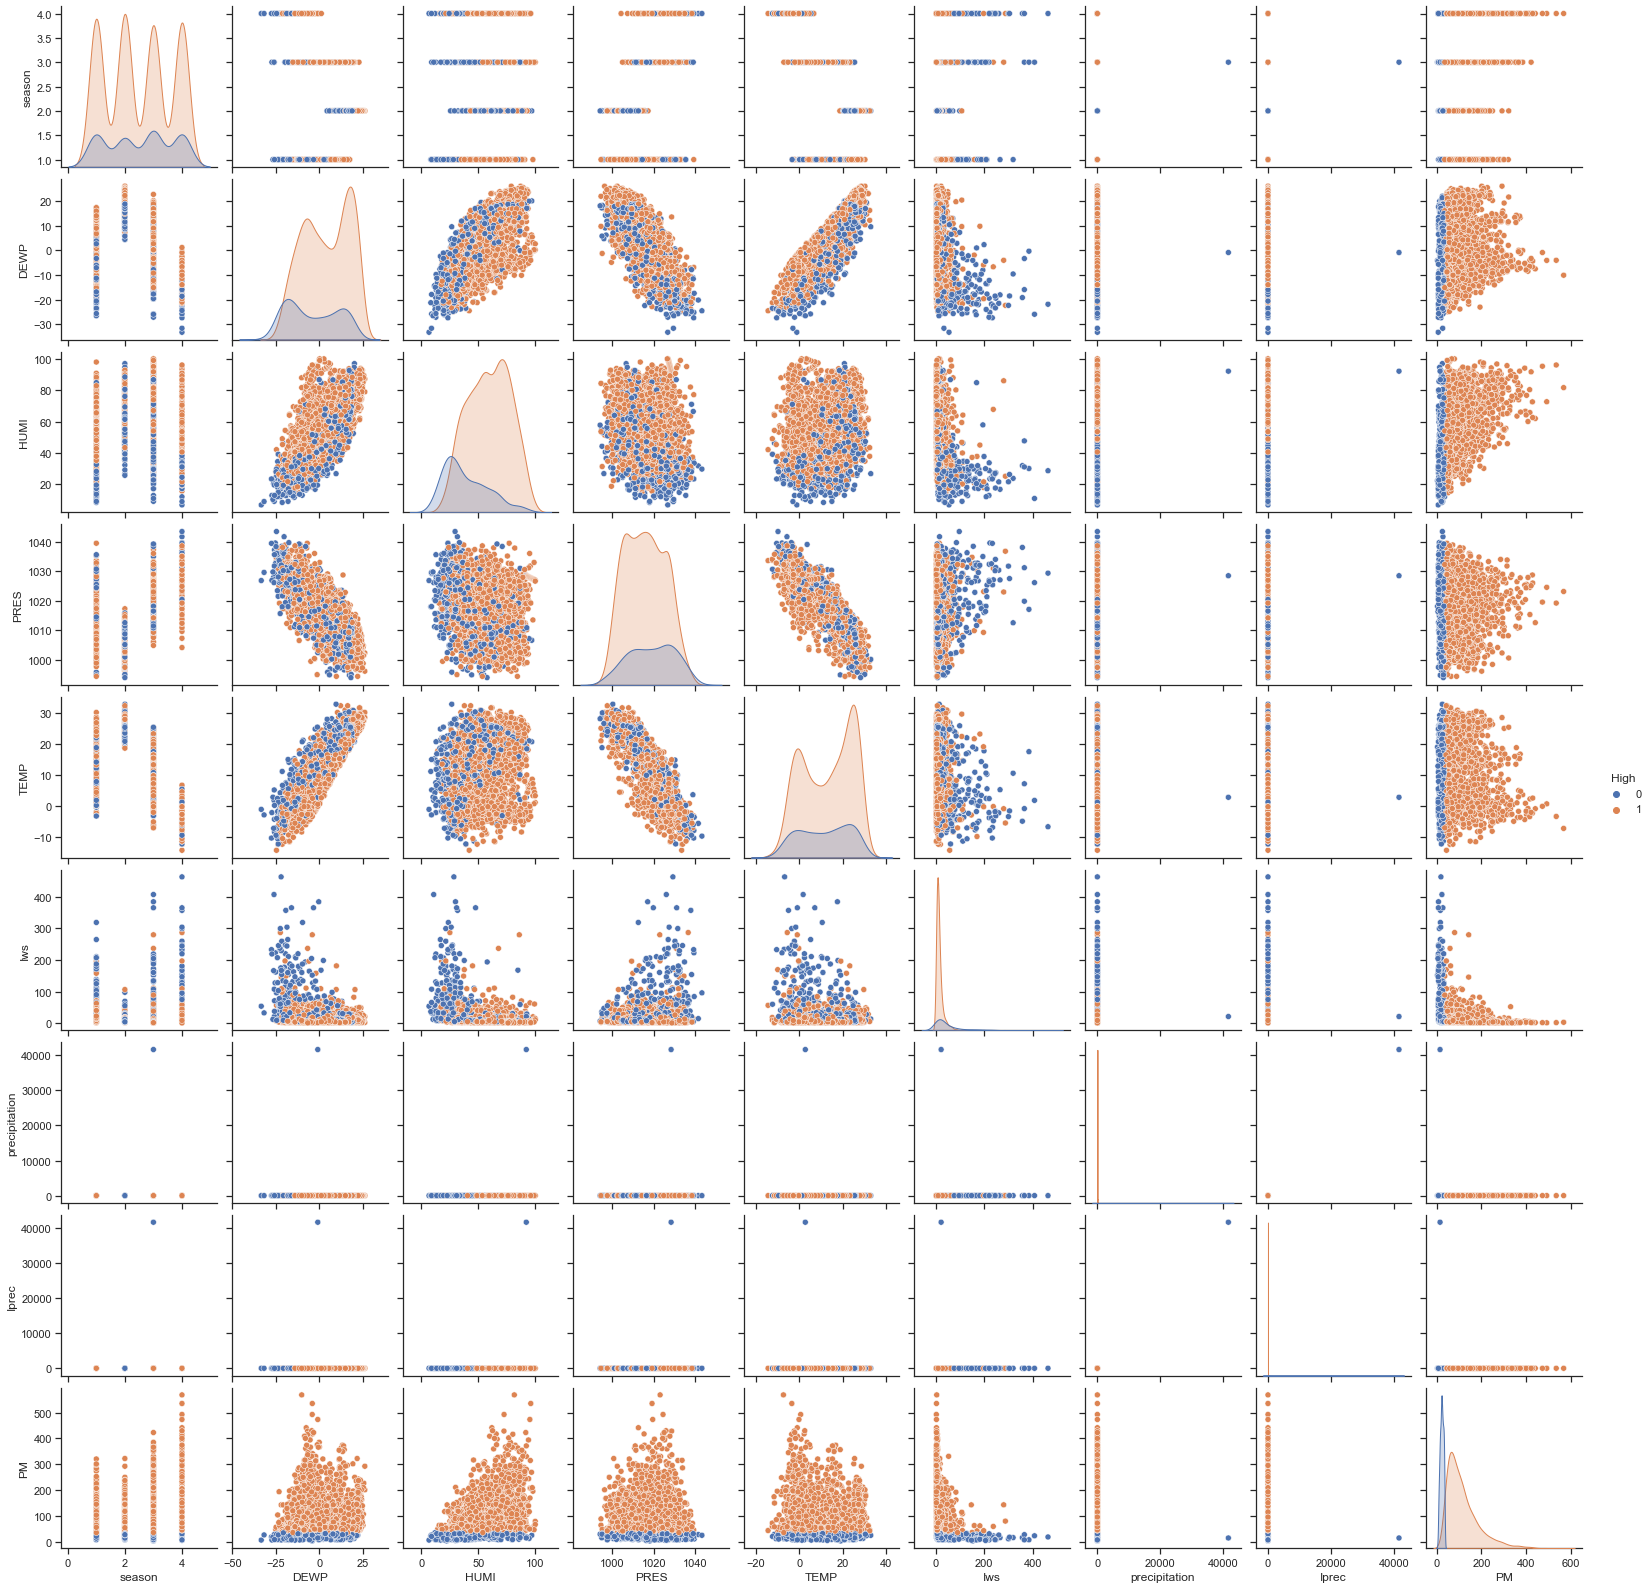

In [1034]:
import seaborn as sns

sns.set_theme(style="ticks")

sns.pairplot(datasets[0], hue="High")
sns.set(rc={'figure.figsize':(12,12)})

plt.show()

We can see that high levels of humidity (HUMI) seem to correlate with high PM2.5 levels. Moreover, low values of cumulated wind speed (Iws) correlate with high levels of PM2.5. This seems intuitively true, as high levels of humidity and low levels of wind speed would cause particulate matter to remain trapped above the city rather than be dispersed across the countryside. These correlations suggest that a multivariate time series approach may be useful, as these variables seem to contain some useful information regarding PM levels.

We also see that some pairs of our predictor variables, such as temperature (TEMP) and dew point (DEWP) or temperature and pressure (PRES), are quite strongly correlated. These variables may be providing us with redundant information and so we may need to consider removing them from the dataset when building and evaluating our models. Moreover, looking at seasonal data, we see that winter (season 4) seems to have the most extreme PM values, which corresponds with our intuition from the previous graph. We can see that the variables which change most dramatically between winter and the other seasons are temperature and dew point, so it is possible that these variables are partially responsible for the extreme PM values we see in the winter.

## 4. Data Modeling

### 4.1 Model Choice

As discussed in the above data exploration section, our all 5 of our particulate matter datasets exhibit strong autocorrelation, suggesting that there is a time series structure which we can exploit. As a result, we will be considering time series approaches to modeling our data. When modeling time series data, we would like to include lagged version of our variables [4]. That is, to predict PM2.5 at time $t$, we would to use PM2.5 data from time $t-1, ..., t-k$ for some value of $k$ [4]. For many time series models, $k$ will represent the *order* of the model, where the order is the number of lagged values we use to predict the next observation [4]. 

Our goal is to predict the number of high PM2.5 days in a rolling, 30 day window. We will use several methods in order to do this. Firstly, we will guess "High" for all datapoints. Since "High" is the more common of the two classes in all of our datasets, guessing "High" for every datapoint represents how we would model the data if we had only minimal information: the frequency of each class in our population. This will provide us with a baseline level of accuracy - the goal for our other models will be to improve upon the accuracy we get from guessing. 

The second model we will make use of is an autoregressive model, frequently denoted as $AR(p)$, where $p$ is the number of lagged variables which we will be using [3]. Autoregressive models are quite common in the empirical literature, especially models with only 1 lagged variable ($AR(1)$ models), due to their ease of analysis and the relatively small number of assumptions that they make [3]. Autoregressive models simply model one time series of data, and the main assumption being made is that future observations in the time series are linearlly related to past observations [3]. We demonstrated in our autocorrelation plot that this is the case for our PM2.5 time series data, so a simple autoregression model is an appropriate place to begin our modeling. 

Lastly, we will implement a long short-term memory (LSTM) neural network. An LSTM is a form of recurrent neural network architecture [7]. Generally, deep neural networks applied to time series data have several advatanges. Firstly, they are able to model highly complex and nonlinear temporal behavior from multiple input sources [7]. In addition, deep neural networks do not need to make any assumptions about the stationarity of the data - they are able to model time series data with changing means and variances quite well [7]. Now, moving from general neural networks to recurrent neural networks, we have that RNNs are able to keep track of arbitrary long-term dependencies in the input sequence [7]. This allows them to model the sorts of temporal dependencies we see in time series data quite well. However, typical RNNs, when trained using back-propagation, tend to have issues where the gradients can tend to 0 or infinity quite easily [2]. LSTMs, on the other hand, partially resolve this issue because they allow gradients to flow unchanged [2]. As a result, they will be our deep learning model of choice for this exercise.

### 4.2 Model Building and Evaluation

We start by building our $AR(p)$ model of the particulate matter time series data. Our goal here is to predict 30 days into the future so that we can derive an estimate for the number of "High" days there will be in that month. In order to do this, we will predict 30 days into the future, compute the classification accuracy, and then add one point from the test data into the training set. We will then use the new training set to predict the next 30 days, and we will continue in this manner until we've reached the end of the test set. For our training and test sets, we will use a standard 80/20 split of the data.

Our choice of $p$, the number of lagged variables to use in our model, will be derived from the autocorrelation plots above. The goal will be to include as many consecutive lags with statistically significant correlations as we can. For Beijing, this appears to be 3 lag variables, while the other cities range from 25 to 30. We will save these values in a list and make use of them, both in this model and in our later LSTM model.

Lastly, we will also compute the classification accuracy where we assume that we guess "High" for all data points. This will provide us with a baseline value of a naive classifier. We will aim to outperform this classification accuracy mark using our two models.

In [1035]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from sklearn.metrics import mean_squared_error
from math import sqrt

#Number of days to predict ahead
predict_ahead = 30

#Number of lags to use for each city
lags_to_use = [3, 25, 30, 25, 30]

#Loop through each separate dataset
for i in range(len(datasets)):
    #Get PM column
    series = datasets[i]["PM"]

    #Extract values from column
    X = series.values

    #Separate into train and test data
    train, test = X[0:int(len(X)*0.8)], X[int(len(X)*0.8):]
    
    #This will store our training data plus the test data we will incrementally add
    history = [x for x in train]

    #These will contain our accuracy estimates for each 30-day window
    rolling_accuracy = []
    rolling_guess = []

    #Loop until the end of the test data
    for t in range(len(test)-predict_ahead+1):
        lag = lags_to_use[i]
        
        #Fit model
        model =  AutoReg(history, lag)
        model_fit = model.fit()
        
        #Get predictions
        yhat = model_fit.predict(start = len(history), end = len(history)+predict_ahead-1, dynamic = True)

        #Get test set PM and prediction PM values
        df_test = pd.DataFrame(test[t:t+predict_ahead], columns = ["PM"])
        df_pred = pd.DataFrame(yhat, columns = ["PM"])

        #Generate our "High" columns
        df_test["High"] = df_test["PM"].apply(high_PM)
        df_pred["High"] = df_pred["PM"].apply(high_PM)
        
        #Calculate accuracy figures for guessing and classification
        guess_high = pd.DataFrame([1] * predict_ahead, columns = ["High"])
        guess_accuracy = sum(df_test["High"] == guess_high["High"])/len(df_test["High"])*100
        classification_accuracy = sum(df_test["High"] == df_pred["High"])/len(df_test["High"])*100

        #Append accuracy numbers to the appropriate lists
        rolling_accuracy.append(classification_accuracy)
        rolling_guess.append(guess_accuracy)

        #Append observation t from the test set to our history set
        history.append(test[t])

    #Calculate average accuracy on each 30-day rolling window
    accuracy = sum(rolling_accuracy)/len(rolling_accuracy)
    guess_accuracy = sum(rolling_guess)/len(rolling_guess)
    
    #Output accuracy figures
    print(names[i] + ' Classification Accuracy: %.3f' % accuracy)
    print(names[i] + ' Guess Accuracy: %.3f \n' % guess_accuracy)

Beijing Classification Accuracy: 70.797
Beijing Guess Accuracy: 70.813 

Chengdu Classification Accuracy: 67.412
Chengdu Guess Accuracy: 71.702 

Guangzhou Classification Accuracy: 45.699
Guangzhou Guess Accuracy: 39.265 

Shanghai Classification Accuracy: 59.091
Shanghai Guess Accuracy: 61.843 

Shenyang Classification Accuracy: 62.526
Shenyang Guess Accuracy: 63.526 



It appears that our $AR(p)$ model is performing similarly to our naive classifier which guess "High" for every data point. This suggests that we may benefit from adding more information through the use of our other predicotrs. Alternatively, we may also be noise limited in the particulate matter time series data. We will attempt to fit the LSTM model making use of all predictors and verify if that improves the classification accuracy.

The data preprocessing for our LSTM model will need to be a bit more extensive. We will explicitly include the lagged variables as columns in our dataset, converting our problem into a superivsed learning problem. Moreover, we will need to scale all of the continuous inputs to fit in the range (0,1). These two changes will allow gradient descent on the network weights to converge more easily [9]. We will then use the model to predict our PM2.5 values and convert these values into labels for "High" and "Not High". Finally, we will compute the classification accuracy of this approach and assess the results.

Beijing:
Test RMSE: 43.497
Classification Accuracy: 60.046 

Chengdu:
Test RMSE: 21.772
Classification Accuracy: 62.835 

Guangzhou:
Test RMSE: 14.222
Classification Accuracy: 46.102 

Shanghai:
Test RMSE: 23.399
Classification Accuracy: 50.694 

Shenyang:
Test RMSE: 42.560
Classification Accuracy: 65.258 



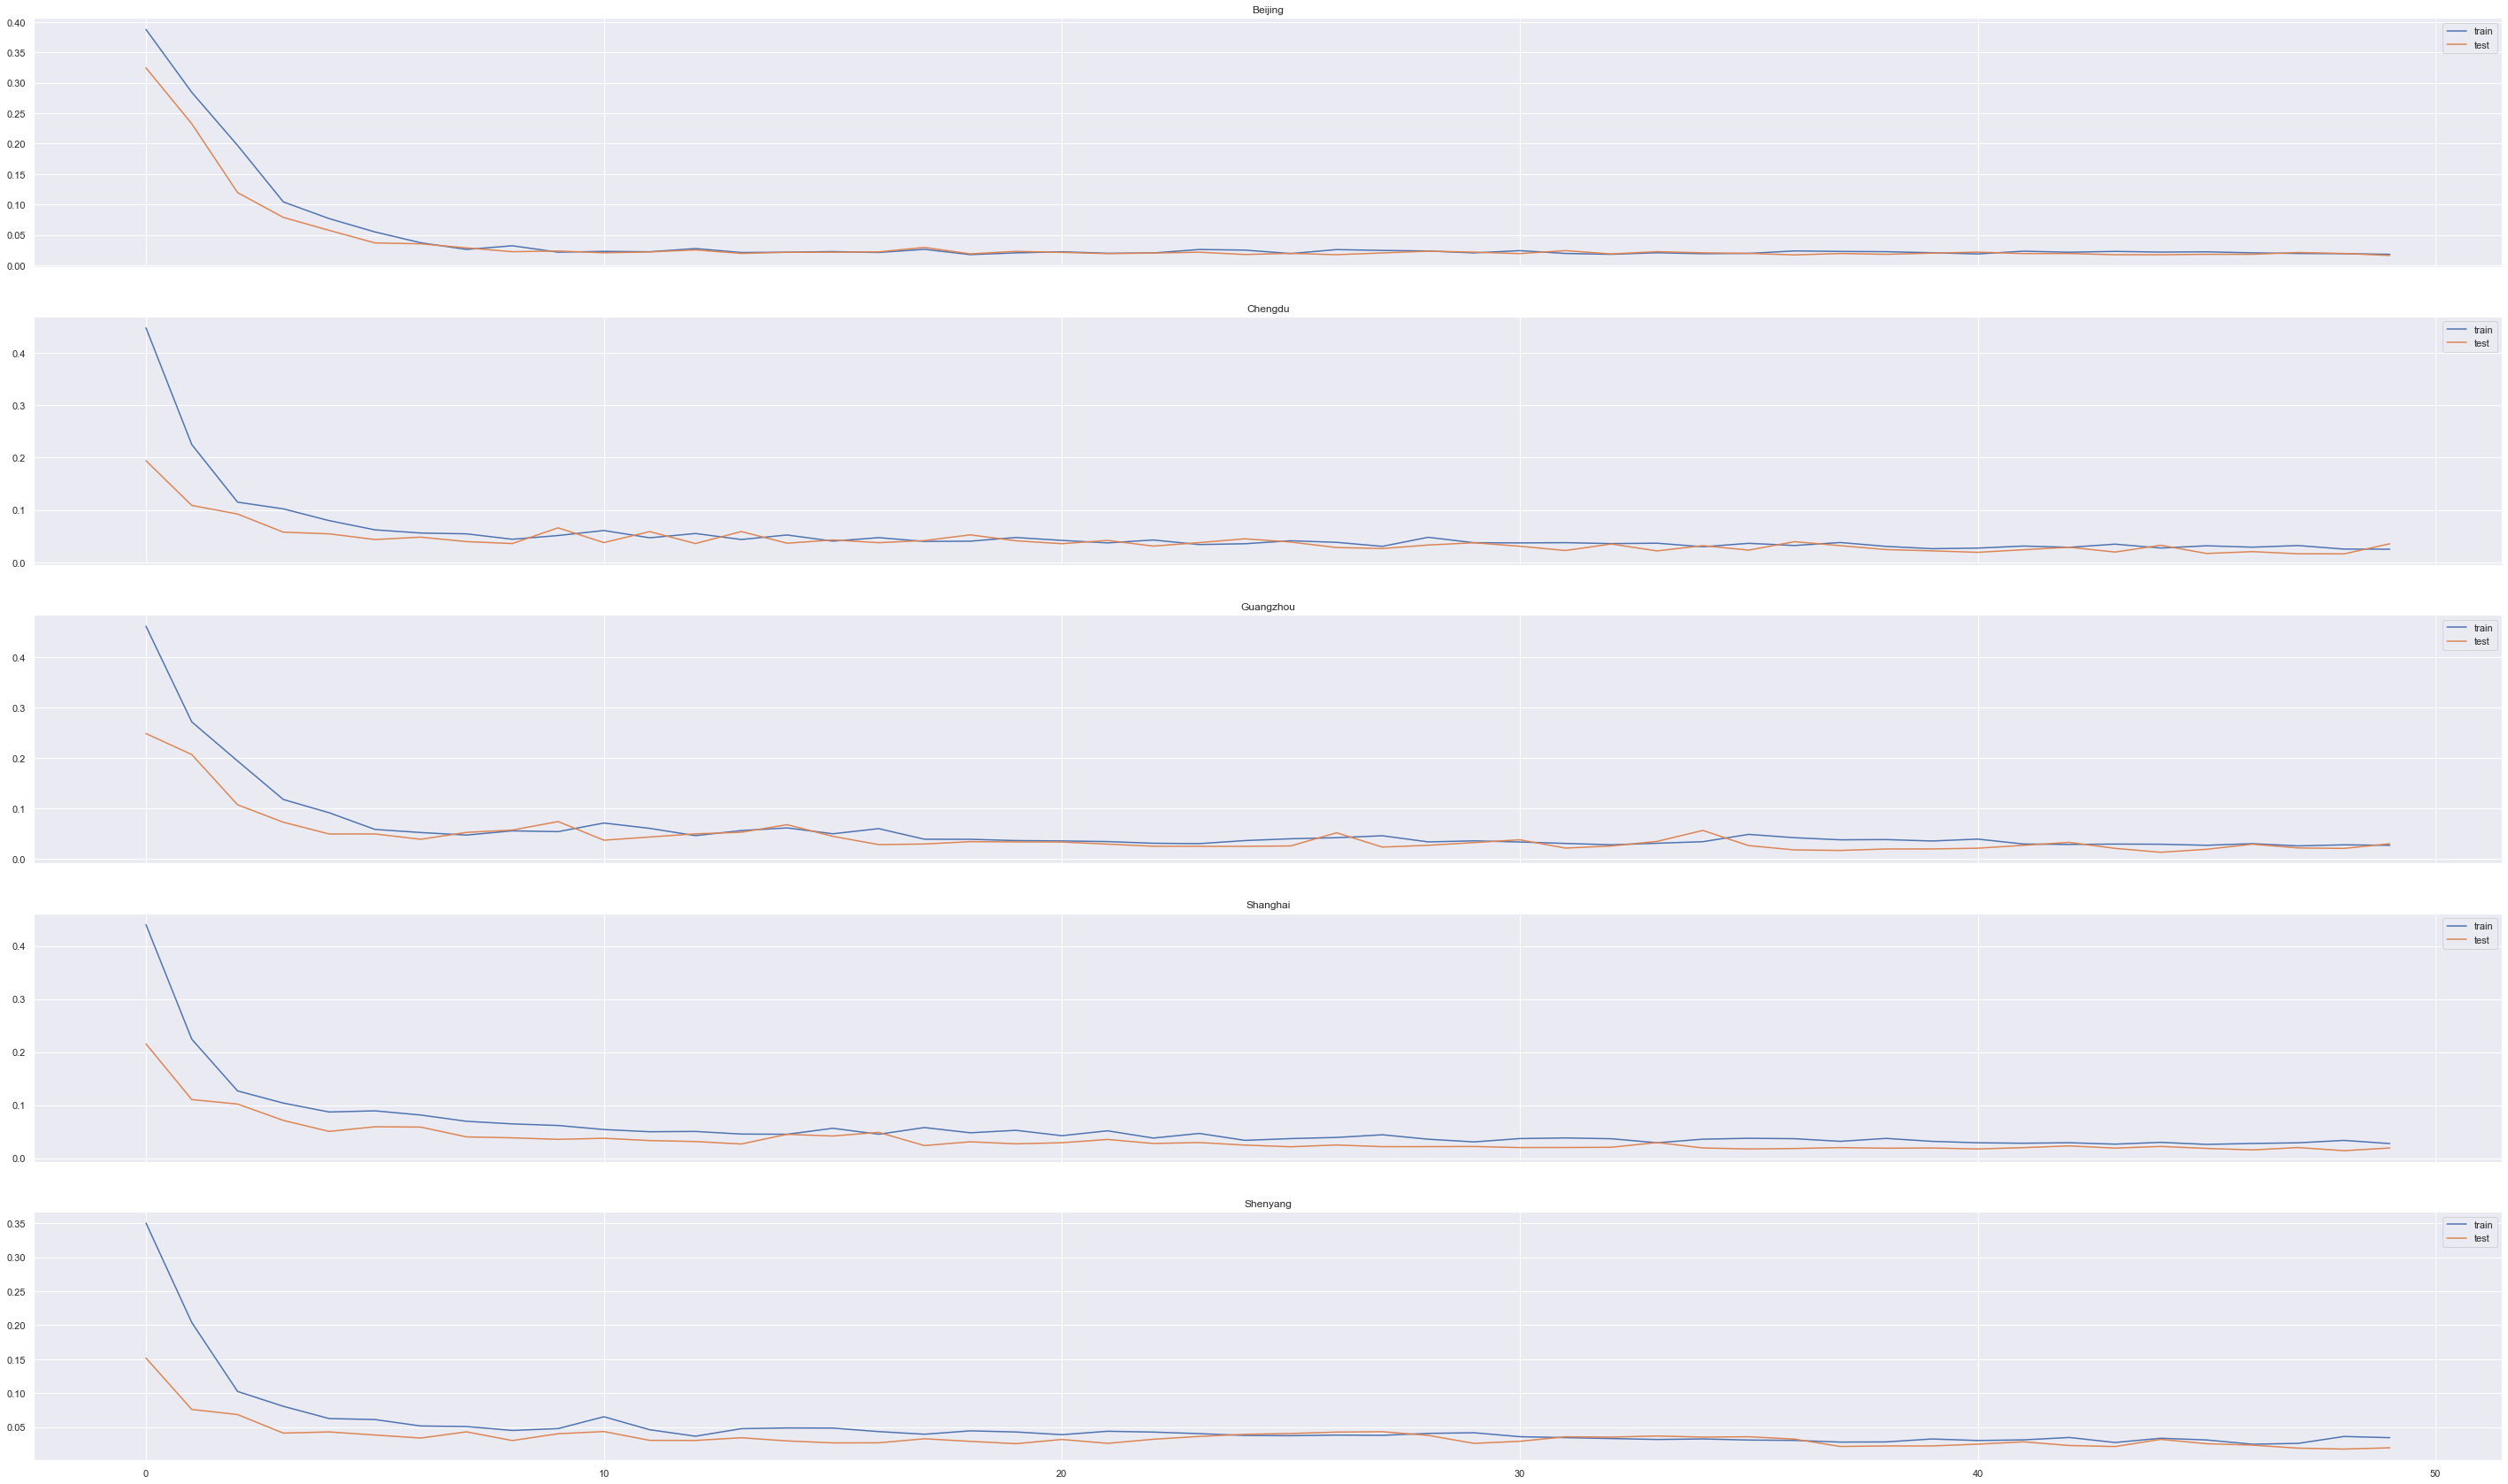

In [1036]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense,LSTM,GRU

#This function will be used to convert our time series into a supervised learning problem
#That is, we will explicity make columns in the dataset for our lagged data
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    #Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    #Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    #Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg

#Set options for plots which we will use later
fig, axes = plt.subplots(ncols=1, nrows=5, sharex=True, figsize=(50,30))

#loop through our datasets
for i in range(len(datasets)):
    #Get the values for our dataset but drop the "High" column
    values = datasets[i].loc[:, datasets[i].columns != "High"].values

    #Encode our season data as an integer
    encoder = LabelEncoder()
    values[:,0] = encoder.fit_transform(values[:,0])
    
    #Ensure all data is float
    values = values.astype('float32')
    
    #Normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)

    #Specify the number of lagged days
    n_days = lags_to_use[i]
    n_features = 9

    #Grame as supervised learning
    reframed = series_to_supervised(scaled, n_days, 1)


    values = reframed.values

    n_train_days = int(0.8*len(values))
    train = values[:n_train_days, :]
    test = values[n_train_days:, :]
    # split into input and outputs
    n_obs = n_days * n_features
    train_X, train_y = train[:, :n_obs], train[:, -n_features]
    test_X, test_y = test[:, :n_obs], test[:, -n_features]

    #Reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
    test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
    
    model = Sequential()
    model.add(LSTM(40, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')

    #Fit network
    history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=0, shuffle=False)
    
    axes[i].plot(history.history['loss'], label='train')
    axes[i].plot(history.history['val_loss'], label='test')
    axes[i].legend()
    axes[i].set_title(names[i])
    
    yhat = model.predict(test_X)
    reshape_test_X = test_X.reshape((test_X.shape[0], n_days*n_features))


    #Invert scaling for forecast
    inv_yhat = np.concatenate((reshape_test_X[:, -n_features+1:], yhat), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,-1]

    #Invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = np.concatenate((reshape_test_X[:, -n_features+1:], test_y), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,-1]


    #Calculate RMSE
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    print(names[i] + ":")
    print('Test RMSE: %.3f' % rmse)


    #Calculate classification accuracy
    test_data = datasets[i][-len(inv_yhat):]
    preds = pd.DataFrame(inv_yhat, columns=["PM"])

    preds["High"] = preds["PM"].apply(high_PM)

    preds["Date"] = test_data.index
    preds.set_index("Date", inplace=True)

    accuracy = sum(preds["High"]==test_data["High"])/(len(test_data["High"]))*100
    print("Classification Accuracy: %.3f \n" % accuracy)
    
#Output plots
plt.show()

## 5. Conclusion

From our above model building and evaluation, we see that both our $AR(p)$ model and our LSTM model fail to improve upon the classification accuracy of guessing the most frequent class. This suggests that we may be noise limited in our data. It is possible that the autoregressive model and LSTM models are both capturing noise rather than the actual trend contained in the time series, which would cause their performance to fall below guessing the most frequent class. If we are indeed noise limited, we may consider using a model with higher bias and lower variance, such as moving average model, which will capture a much smaller portion of the noise in the data. Alternatively, we may also consider attempting to use time series classification techniques. In our approach above, we first ran a regression on the particulate matter data and manually classified the predictions based upon whether they fell above or below our selected threshold. An approach using a time series classifier, such as a time series forest (TSF), trained directly on the class labels of "High" and "Not High" may see more success on these datasets.

## 6. References

[1] Fuzzi, S. et al. "Particulate matter, air quality and climate: lessons learned and future needs." Atmos. Chem. Phys., 15 (2016):8217–8299, https://doi.org/10.5194/acp-15-8217-2015

[2] Goodfellow, Ian, et al. *Deep Learning*. The MIT Press, 2017. 

[3] Greene, William H. *Econometric Analysis*. 8th ed., Pearson, 2018. 

[4] Hilton, James D. *Time Series Analysis*. Princeton University Press, 1994. 

[5] Hyndman, R.J., & Athanasopoulos, G. (2021) *Forecasting: principles and practice*, 3rd edition, OTexts: Melbourne, Australia. OTexts.com/fpp3.

[6] Kutner, Michael H., et al. *Applied Linear Statistical Models*. 5th ed., McGraw-Hill Education, 2005. 

[7] Lazzeri, Francesca. *Machine Learning for Time Series Forecasting with Python*. John Wiley & Sons, Inc., 2020. 

[8] “National Ambient Air Quality Standards (NAAQS) for PM.” EPA, Environmental Protection Agency, 10 June 2021, www.epa.gov/pm-pollution/national-ambient-air-quality-standards-naaqs-pm. 

[9] Nielsen, Aileen. *Practical Time Series Analysis: Prediction with Statistics and Machine Learning*. O'Reilly, 2020. 

[10] Xing, Yu-Fei et al. “The impact of PM2.5 on the human respiratory system.” Journal of thoracic disease vol. 8,1 (2016): E69-74. doi:10.3978/j.issn.2072-1439.2016.01.19

[11] Xu, Jinwei et al. "Air-Filtering Masks for Respiratory Protection from PM2.5 and Pandemic Pathogens." One Earth, Volume 3, Issue 5, Pages 574-589 (2020): ISSN 2590-3322, https://doi.org/10.1016/j.oneear.2020.10.014.